# Оптимизациия энергопотребления на этапе обработки стали.

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

**Описание этапа обработки**

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).


**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

# План решения задачи

Решение задачи пройдёт в четыре основных этапа:
1. Загрузка и исследование данных
 - Поиск аномалий
 - Поиск пропусков
2. Предобработка данных
 - Обработка пропусков
 - Удаление аномалий
 - Пдготовка признаков
 - Объединение таблиц
 - Проверка на мультиколлинеарность
 - Разделение данных на выборки
3. Построение моделей машинного обучения
 - LightGBM
 - CatBoost
 - LinearRegression
 - Ridge Regression
4. Анализ работы моделей и подготовка отчёта
 - Сравнение моделей
 - Проверка модели на тестовой выборке
 - Значимость признаков
 - Отчёт по решению

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-необходимых-библиотек-и-данных" data-toc-modified-id="Загрузка-необходимых-библиотек-и-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка необходимых библиотек и данных</a></span><ul class="toc-item"><li><span><a href="#Загрузка-библиотек" data-toc-modified-id="Загрузка-библиотек-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Загрузка библиотек</a></span></li><li><span><a href="#Загрузка-и-исследование-данных" data-toc-modified-id="Загрузка-и-исследование-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Загрузка и исследование данных</a></span><ul class="toc-item"><li><span><a href="#Данные-об-электродах" data-toc-modified-id="Данные-об-электродах-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Данные об электродах</a></span></li><li><span><a href="#Данные-о-подаче-сыпучих-материалов-(объём)" data-toc-modified-id="Данные-о-подаче-сыпучих-материалов-(объём)-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Данные о подаче сыпучих материалов (объём)</a></span></li><li><span><a href="#Данные-о-подаче-сыпучих-материалов-(время)" data-toc-modified-id="Данные-о-подаче-сыпучих-материалов-(время)-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Данные о подаче сыпучих материалов (время)</a></span></li><li><span><a href="#Данные-о-продувке-сплава-газом" data-toc-modified-id="Данные-о-продувке-сплава-газом-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Данные о продувке сплава газом</a></span></li><li><span><a href="#Результаты-измерения-температуры" data-toc-modified-id="Результаты-измерения-температуры-1.2.5"><span class="toc-item-num">1.2.5&nbsp;&nbsp;</span>Результаты измерения температуры</a></span></li><li><span><a href="#Данные-о-проволочных-материалах-(объём)" data-toc-modified-id="Данные-о-проволочных-материалах-(объём)-1.2.6"><span class="toc-item-num">1.2.6&nbsp;&nbsp;</span>Данные о проволочных материалах (объём)</a></span></li><li><span><a href="#Данные-о-проволочных-материалах-(время)" data-toc-modified-id="Данные-о-проволочных-материалах-(время)-1.2.7"><span class="toc-item-num">1.2.7&nbsp;&nbsp;</span>Данные о проволочных материалах (время)</a></span></li></ul></li></ul></li><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Предобработка данных</a></span><ul class="toc-item"><li><span><a href="#Обработка-пропусков,-удаление-аномалий,-подготовка-признаков" data-toc-modified-id="Обработка-пропусков,-удаление-аномалий,-подготовка-признаков-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Обработка пропусков, удаление аномалий, подготовка признаков</a></span></li><li><span><a href="#Объединение-таблиц" data-toc-modified-id="Объединение-таблиц-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Объединение таблиц</a></span></li><li><span><a href="#Проверка-на-мультиколлинеарность" data-toc-modified-id="Проверка-на-мультиколлинеарность-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Проверка на мультиколлинеарность</a></span></li><li><span><a href="#Разделение-данных-на-выборки" data-toc-modified-id="Разделение-данных-на-выборки-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Разделение данных на выборки</a></span></li></ul></li><li><span><a href="#Построение-моделей-машинного-обучения" data-toc-modified-id="Построение-моделей-машинного-обучения-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Построение моделей машинного обучения</a></span><ul class="toc-item"><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#CatBoostRegressor" data-toc-modified-id="CatBoostRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CatBoostRegressor</a></span></li><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#Ridge-Regression" data-toc-modified-id="Ridge-Regression-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Ridge Regression</a></span></li></ul></li><li><span><a href="#Анализ-работы-моделей-и-подготовка-отчёта" data-toc-modified-id="Анализ-работы-моделей-и-подготовка-отчёта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Анализ работы моделей и подготовка отчёта</a></span><ul class="toc-item"><li><span><a href="#Сравнение-моделей" data-toc-modified-id="Сравнение-моделей-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Сравнение моделей</a></span></li><li><span><a href="#Проверка-модели-на-тестовой-выборке" data-toc-modified-id="Проверка-модели-на-тестовой-выборке-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Проверка модели на тестовой выборке</a></span></li><li><span><a href="#Значимость-признаков" data-toc-modified-id="Значимость-признаков-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Значимость признаков</a></span></li><li><span><a href="#Отчёт-по-решению" data-toc-modified-id="Отчёт-по-решению-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Отчёт по решению</a></span></li></ul></li></ul></div>

## Загрузка необходимых библиотек и данных

In [ ]:
%%capture
! pip install phik
! pip install catboost

### Загрузка библиотек

In [ ]:
import pandas as pd
import numpy as np
import phik

# vizualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
plt.style.use('seaborn-whitegrid')

# ml
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge
import lightgbm as lgb
from catboost import CatBoostRegressor

# options
pd.options.display.float_format = '{:,.4f}'.format
import warnings
warnings.filterwarnings("ignore")

# seed freezing
seed = 29082022
np.random.seed(seed)

print('Setup complete')

Setup complete


### Загрузка и исследование данных

In [ ]:
! gdown 1wRLJFGINGdu7RdQEc88Avghz8yyHN_O2

/bin/bash: gdown: command not found


In [ ]:
! unzip -o /content/final_steel.zip

/bin/bash: unzip: command not found


In [ ]:
try:
  data_arc = pd.read_csv('final_steel/data_arc.csv')
  data_wire = pd.read_csv('final_steel/data_wire.csv')
  data_temp = pd.read_csv('final_steel/data_temp.csv')
  data_gas = pd.read_csv('final_steel/data_gas.csv')
  data_bulk = pd.read_csv('final_steel/data_bulk.csv')
  data_wire_time = pd.read_csv('final_steel/data_wire_time.csv')
  data_bulk_time = pd.read_csv('final_steel/data_bulk_time.csv')
except:
  data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv')
  data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv')
  data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv')
  data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv')
  data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv')
  data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv')
  data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv')

In [ ]:
def get_info(df):
  display(df.head(), df.info(), df.describe(include = 'all').T)
  print('Процент пропусков:\n', df.isna().mean().sort_values(ascending=False)*100)

Посмотрим каждый дадасет по отдельности.   

In [ ]:
def vizualize(df, column):
  plt.figure(figsize=(10,5))
  df[column].hist(bins=100, ec='black')
  plt.title('Распределение ' + str(column), size=20)
  plt.show()
  print('')
  plt.figure(figsize=(10,5))
  sns.boxplot(df[column]);

#### Данные об электродах

In [ ]:
get_info(data_arc)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.9761,0.6871
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.8056,0.5203
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.7444,0.4988
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.6594,1.0627
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.6928,0.4144


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
key,"14,876.0000",NaN,NaN,NaN,"1,615.2204",934.5715,1.0000,806.0000,"1,617.0000","2,429.0000","3,241.0000"
Начало нагрева дугой,14876,14875,2019-06-10 22:02:03,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Конец нагрева дугой,14876,14876,2019-05-25 11:33:25,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Активная мощность,"14,876.0000",NaN,NaN,NaN,0.6704,0.4082,0.0300,0.3953,0.5555,0.8570,3.7316
Реактивная мощность,"14,876.0000",NaN,NaN,NaN,0.4526,5.8787,-715.5049,0.2910,0.4160,0.6374,2.6764


Процент пропусков:
 key                    0.0000
Начало нагрева дугой   0.0000
Конец нагрева дугой    0.0000
Активная мощность      0.0000
Реактивная мощность    0.0000
dtype: float64


In [ ]:
data_arc[data_arc['Реактивная мощность'] < 0]['Реактивная мощность'].value_counts()

-715.5049    1
Name: Реактивная мощность, dtype: int64

Посмотрим на распределение кол-ва итераций для каждой партии

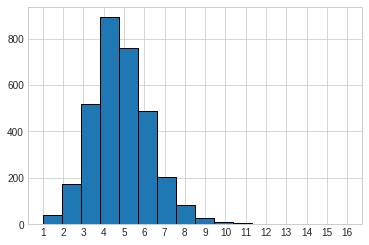

In [ ]:
data_arc['key'].value_counts().hist(bins=16, ec='black')
plt.xticks(range(1,17));

Здесь можем выделить следующие моменты:
- Дату и время следует привести к правильному формату
- Названия столбцов следует исправить
- Реактивная мощность имеет одно сильно отличающееся отрицательное значение (Необходимо уточнить у заказчика природу таких значений, а это будем удалять или попытаемся посчитать)
- В основном партии требуется пройти 3-5 итераций

#### Данные о подаче сыпучих материалов (объём)

In [ ]:
get_info(data_bulk)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0000,NaN,150.0000,154.0000
1,2,NaN,NaN,NaN,73.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0000,NaN,149.0000,154.0000
2,3,NaN,NaN,NaN,34.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0000,NaN,152.0000,153.0000
3,4,NaN,NaN,NaN,81.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0000,NaN,153.0000,154.0000
4,5,NaN,NaN,NaN,78.0000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0000,NaN,151.0000,152.0000


None

,count,mean,std,min,25%,50%,75%,max
key,"3,129.0000","1,624.3835",933.3376,1.0000,816.0000,"1,622.0000","2,431.0000","3,241.0000"
Bulk 1,252.0000,39.2421,18.2777,10.0000,27.0000,31.0000,46.0000,185.0000
Bulk 2,22.0000,253.0455,21.1806,228.0000,242.0000,251.5000,257.7500,325.0000
Bulk 3,"1,298.0000",113.8790,75.4835,6.0000,58.0000,97.5000,152.0000,454.0000
Bulk 4,"1,014.0000",104.3945,48.1841,12.0000,72.0000,102.0000,133.0000,281.0000
Bulk 5,77.0000,107.0260,81.7906,11.0000,70.0000,86.0000,132.0000,603.0000
Bulk 6,576.0000,118.9253,72.0578,17.0000,69.7500,100.0000,157.0000,503.0000
Bulk 7,25.0000,305.6000,191.0229,47.0000,155.0000,298.0000,406.0000,772.0000
Bulk 8,1.0000,49.0000,NaN,49.0000,49.0000,49.0000,49.0000,49.0000
Bulk 9,19.0000,76.3158,21.7206,63.0000,66.0000,68.0000,70.5000,147.0000


Процент пропусков:
 Bulk 8    99.9680
Bulk 13   99.4247
Bulk 9    99.3928
Bulk 2    99.2969
Bulk 7    99.2010
Bulk 5    97.5391
Bulk 10   94.3752
Bulk 11   94.3432
Bulk 1    91.9463
Bulk 6    81.5916
Bulk 4    67.5935
Bulk 3    58.5171
Bulk 15   28.1560
Bulk 12   21.7002
Bulk 14   10.3228
key        0.0000
dtype: float64


Здесь мы видим большое количество пропусков, скорее всего это говорит о том, что легирующие элементы не добавлялись, поэтому пропуски можно заменить нулями.

#### Данные о подаче сыпучих материалов (время)

In [ ]:
get_info(data_bulk_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
key,"3,129.0000",NaN,NaN,NaN,"1,624.3835",933.3376,1.0000,816.0000,"1,622.0000","2,431.0000","3,241.0000"
Bulk 1,252,252,2019-06-26 23:51:04,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 2,22,22,2019-08-08 14:33:22,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 3,1298,1298,2019-05-08 05:42:08,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 4,1014,1014,2019-08-06 00:12:53,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 5,77,77,2019-08-12 11:31:20,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 6,576,576,2019-08-19 06:44:11,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 7,25,25,2019-08-08 14:45:03,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 8,1,1,2019-07-05 17:46:11,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Bulk 9,19,19,2019-08-11 13:20:19,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Процент пропусков:
 Bulk 8    99.9680
Bulk 13   99.4247
Bulk 9    99.3928
Bulk 2    99.2969
Bulk 7    99.2010
Bulk 5    97.5391
Bulk 10   94.3752
Bulk 11   94.3432
Bulk 1    91.9463
Bulk 6    81.5916
Bulk 4    67.5935
Bulk 3    58.5171
Bulk 15   28.1560
Bulk 12   21.7002
Bulk 14   10.3228
key        0.0000
dtype: float64


Здесь, как мы уже отметили ранее, пропущенные значения говорят о том легирующих элементов не добавлялось. Дату и время так же следует привести к правильному формату.

#### Данные о продувке сплава газом

In [ ]:
get_info(data_gas)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


,key,Газ 1
0,1,29.7500
1,2,12.5556
2,3,28.5548
3,4,18.8412
4,5,5.4137


None

,count,mean,std,min,25%,50%,75%,max
key,"3,239.0000","1,621.8614",935.3863,1.0000,812.5000,"1,622.0000","2,431.5000","3,241.0000"
Газ 1,"3,239.0000",11.0021,6.2203,0.0084,7.0431,9.8363,13.7699,77.9950


Процент пропусков:
 key     0.0000
Газ 1   0.0000
dtype: float64


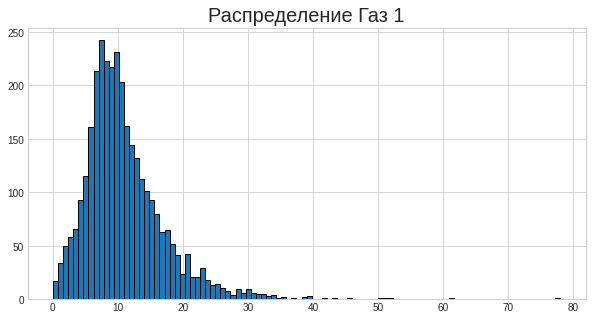

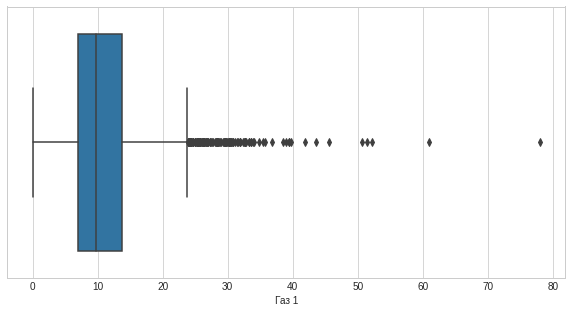

In [ ]:
vizualize(data_gas, 'Газ 1')

Посмотрим на пределы нормальных значений

In [ ]:
q25 = np.array(data_gas['Газ 1'].quantile(0.25))
q75 = np.array(data_gas['Газ 1'].quantile(0.75))
print('25% - ',q25, '75% - ', q75)
print('Верхний порог', q75+3*(q75-q25))
print('Кол-во партий с аномально большим объёмом', data_gas[data_gas['Газ 1'] > q75+3*(q75-q25)]['key'].count())

25% -  7.04308867105 75% -  13.7699154369
Верхний порог 33.95039573445
Кол-во партий с аномально большим объёмом 18


Здесь можно выделить маленькие значения близкие к нулю и некотрые выбросы в большую сторону. Следуют уточнить как собираются эти данные, что бы понять природу таких значений. Нормальные значения расположены в диапазоне *7,04 - 13,77*. Верхний порог, за которым скорее всего расположены выбросы *33,95*, но не смотря на то что таких значений всего *18*, трогать их без согласования с заказчиком не будем. Так же следует уточнить как разделить имеющиеся данные по газу на кол-во итераций при легировании.

#### Результаты измерения температуры

In [ ]:
get_info(data_temp)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


,key,Время замера,Температура
0,1,2019-05-03 11:16:18,"1,571.0000"
1,1,2019-05-03 11:25:53,"1,604.0000"
2,1,2019-05-03 11:29:11,"1,618.0000"
3,1,2019-05-03 11:30:01,"1,601.0000"
4,1,2019-05-03 11:30:39,"1,613.0000"


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
key,"15,907.0000",NaN,NaN,NaN,"1,607.8809",942.2121,1.0000,790.0000,"1,618.0000","2,427.0000","3,241.0000"
Время замера,15907,15907,2019-06-12 02:29:53,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Температура,"13,006.0000",NaN,NaN,NaN,"1,591.8409",21.3759,"1,191.0000","1,581.0000","1,591.0000","1,601.0000","1,705.0000"


Процент пропусков:
 Температура    18.2373
key             0.0000
Время замера    0.0000
dtype: float64


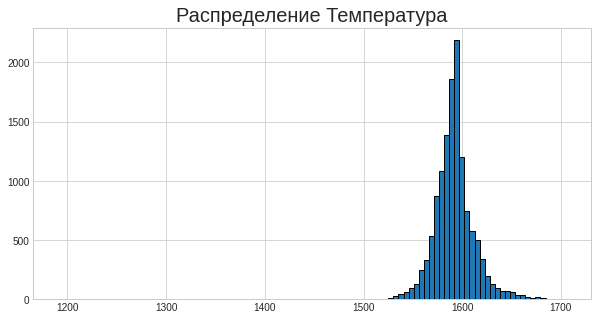

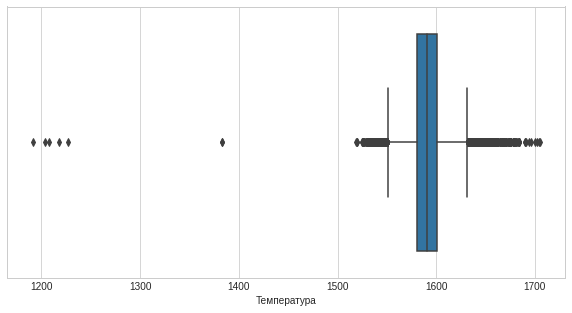

In [ ]:
vizualize(data_temp, 'Температура')

Здесь следует отметить наличие пропусков в значениях температуры 18,24% от всех данных. Есть выбросы в минимальную сторону, по паспорту минимальная температура 1400 градусов. Дату и время так же следует привести к праввильному формату.

#### Данные о проволочных материалах (объём)

In [ ]:
get_info(data_wire)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.0600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.0523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.1602,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.0635,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.2382,9.1146,NaN,NaN,NaN,NaN,NaN,NaN,NaN


None

,count,mean,std,min,25%,50%,75%,max
key,"3,081.0000","1,623.4265",932.9967,1.0000,823.0000,"1,619.0000","2,434.0000","3,241.0000"
Wire 1,"3,055.0000",100.8959,42.0125,1.9188,72.1157,100.1582,126.0605,330.3144
Wire 2,"1,079.0000",50.5773,39.3202,0.0302,20.1937,40.1430,70.2276,282.7802
Wire 3,63.0000,189.4827,99.5134,0.1441,95.1350,235.1950,276.2520,385.0087
Wire 4,14.0000,57.4428,28.8247,24.1488,40.8070,45.2343,76.1246,113.2310
Wire 5,1.0000,15.1320,NaN,15.1320,15.1320,15.1320,15.1320,15.1320
Wire 6,73.0000,48.0170,33.9198,0.0343,25.0536,42.0763,64.2127,180.4546
Wire 7,11.0000,10.0390,8.6106,0.2342,6.7628,9.0170,11.8861,32.8477
Wire 8,19.0000,53.6252,16.8817,45.0767,46.0949,46.2800,48.0896,102.7624
Wire 9,29.0000,34.1558,19.9316,4.6228,22.0584,30.0664,43.8620,90.0536


Процент пропусков:
 Wire 5   99.9675
Wire 7   99.6430
Wire 4   99.5456
Wire 8   99.3833
Wire 9   99.0587
Wire 3   97.9552
Wire 6   97.6306
Wire 2   64.9789
Wire 1    0.8439
key       0.0000
dtype: float64


Здесь не видно ничего подозрительного, стоит только отметить что проволка первого типа добавляется практически в 99% случаях. Пропущенные значения можно заменить нулями.

#### Данные о проволочных материалах (время)

In [ ]:
get_info(data_wire_time)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


None

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
key,"3,081.0000",NaN,NaN,NaN,"1,623.4265",932.9967,1.0000,823.0000,"1,619.0000","2,434.0000","3,241.0000"
Wire 1,3055,3055,2019-05-25 02:06:31,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 2,1079,1079,2019-06-04 06:29:52,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 3,63,63,2019-06-12 01:29:02,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 4,14,14,2019-07-17 11:25:32,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 5,1,1,2019-08-08 16:01:07,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 6,73,73,2019-05-07 11:38:44,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 7,11,11,2019-07-23 12:08:44,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 8,19,19,2019-05-14 01:08:35,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Wire 9,29,29,2019-06-01 02:25:26,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Процент пропусков:
 Wire 5   99.9675
Wire 7   99.6430
Wire 4   99.5456
Wire 8   99.3833
Wire 9   99.0587
Wire 3   97.9552
Wire 6   97.6306
Wire 2   64.9789
Wire 1    0.8439
key       0.0000
dtype: float64


Здесь так же стоит привести все столбцы к нужному формату.

## Предобработка данных

### Обработка пропусков, удаление аномалий, подготовка признаков

Приведём наши данные в некоторый порядок
- `data_arc` - Переименуем столбцы, посчитаем и заменим аномальное значение, посчитаем полную мощность, энергию и время нагрева.
- `data_bulk` - Преименуем столбцы, заполним пропуски нулями
- `data_bulk_time` - эти данные не будем использовать, так как они имеют ошибочные значения
- `data_gas` - Переименуем столбец
- `data_temp` - Нас интересует только начальная температура для кажой партии. её будем и оставлять как признак, конечная температура является нашим целевым признаком.
- `data_wire` - Преименуем столбцы, заполним пропуски нулями
- `data_wire_time` - эти данные не будем использовать, так как они имеют ошибочные значения 

In [ ]:
# delete unnecessary data

del data_wire_time, data_bulk_time

In [ ]:
# Let's name column in snake_registry
data_arc.columns = ['key', 'start_heating', 'finish_heating', 'active_power', 'reactive_power']
# datetime
data_arc[['start_heating', 'finish_heating']] = data_arc[['start_heating', 'finish_heating']].astype('datetime64')

Посмотрим на аномальное значение реактивной мощности

In [ ]:
data_arc[data_arc['reactive_power'] < 0]

,key,start_heating,finish_heating,active_power,reactive_power
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.4958,-715.5049


Посмотрим какие значения имеются для партии 2116

In [ ]:
data_arc[data_arc['key'] == 2116]

,key,start_heating,finish_heating,active_power,reactive_power
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.4333,0.3061
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.6203,0.4084
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.4958,-715.5049
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.2994,0.1988


У нас выбивается только одно значение из партии, лучше заменить его на какое-то значение. Посмотрим есть ли кореляция между активной и реактивной мощностями и сможем ли мы рассчитать рективную мощьность по активной.

In [ ]:
fig = px.scatter(data_arc.query("key == 2116 and reactive_power > 0"), 
                 x="active_power", 
                 y="reactive_power",
                 trendline="ols",)

#fig.show()
results = px.get_trendline_results(fig)
print(results.px_fit_results.iloc[0].summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     82.90
Date:                Tue, 06 Sep 2022   Prob (F-statistic):             0.0696
Time:                        05:07:18   Log-Likelihood:                 9.7633
No. Observations:                   3   AIC:                            -15.53
Df Residuals:                       1   BIC:                            -17.33
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0130      0.033      0.390      0.7

/opt/conda/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning:

omni_normtest is not valid with less than 8 observations; 3 samples were given.



Есть зависимость такого вида active_power * 0.6463 + 0.0130. Для замены одного значения вполне сгодится.

In [ ]:
data_arc.at[9780, 'reactive_power'] = data_arc.iloc[9780].active_power*0.6463 + 0.0130
data_arc[data_arc['key'] == 2116]

,key,start_heating,finish_heating,active_power,reactive_power
9778,2116,2019-07-24 00:29:52,2019-07-24 00:31:54,0.4333,0.3061
9779,2116,2019-07-24 00:35:50,2019-07-24 00:38:05,0.6203,0.4084
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.4958,0.3334
9781,2116,2019-07-24 00:51:51,2019-07-24 00:52:58,0.2994,0.1988


Напишем функцию для подсчёта полной мощности, энергии и время нагрева. Так же объединим данные по значению `key` просуммировав значения.

In [ ]:
def new_features_arc(df):
  # Count apparent_power, duration_heating, energy
  df['apparent_power'] = (df['active_power']**2 + df['reactive_power']**2)**0.5
  df['duration_heating'] = (df['finish_heating'] - df['start_heating']) / np.timedelta64(1, 'm')
  df['energy'] = df['apparent_power'] * df['duration_heating']
  
  

  # Group by 'key'
  df = df.groupby('key').agg({'start_heating': 'min',
                              'finish_heating': 'max',
                              'active_power': 'sum',
                              'reactive_power': 'sum',
                              'apparent_power': 'sum',
                              'duration_heating': 'sum',
                              'energy': 'sum',
                              'key': 'count'
                              })
  
  # rename colum, reset indexes and drop datatime columns
  df = df.rename(columns={'key': 'qty_iterations'})
  df.reset_index(inplace=True)
  
  # Date features
  df['weekday'] = df['start_heating'].dt.weekday
  df['month'] = df['start_heating'].dt.month
  df['hour'] = df['start_heating'].dt.hour

  df = df.drop(['start_heating', 'finish_heating'], axis=1)

  return df

In [ ]:
data_arc = new_features_arc(data_arc)
data_arc.head()

,key,active_power,reactive_power,apparent_power,duration_heating,energy,qty_iterations,weekday,month,hour
0,1,4.8781,3.1832,5.8264,18.3000,24.0396,5,4,5,11
1,2,3.0526,1.9981,3.6492,13.5167,14.6872,4,4,5,11
2,3,2.5259,1.5991,2.9895,10.9167,8.7511,5,4,5,12
3,4,3.2093,2.0603,3.8150,12.3500,13.2819,4,4,5,12
4,5,3.3472,2.2526,4.0358,14.4833,19.9856,4,4,5,13


Посмотрим на распределение продолжительности нагрева.

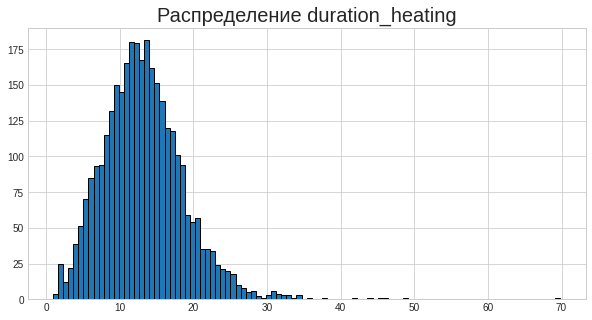

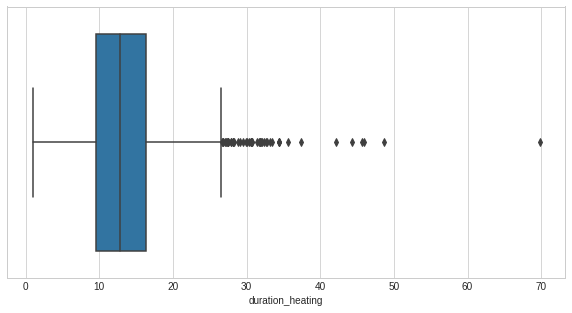

In [ ]:
vizualize(data_arc, 'duration_heating')

Здесь так же видны выбросы в большую сторону, но пока их трогать без согласования с заказчиком не будем.

Напишем функцию для перевода столбцов к змеиному регистру, заменим пропуски нулями в этих таблицах, посчитаем сумму легирующих элементов и их кол-во.

In [ ]:
def bulk_and_wire_prep(df):
  # snake_register
  correct_columns = []
  for column in df.columns:
    snake_register = ''
    sep = '_'
    for i in column:
      if i.isupper():
        snake_register += sep + i.lower()
      else:
        snake_register += i
    snake_register = snake_register.replace(' ', '_')
    correct_columns.append(snake_register.lstrip(sep))
  df.columns = correct_columns

  # Group by 'key', count sum and qty
  df[correct_columns[1].rstrip('1') + 'sum'] = df.drop('key', axis=1).sum(axis=1).values
  df[correct_columns[1].rstrip('1') + 'count'] = df.notnull().drop('key', axis=1).sum(axis=1).values - 1

  # Fill nan
  df.fillna(0, inplace=True)

  return df

In [ ]:
data_bulk = bulk_and_wire_prep(data_bulk)
data_wire = bulk_and_wire_prep(data_wire)
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_sum,bulk_count
0,1,0.0000,0.0000,0.0000,43.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,206.0000,0.0000,150.0000,154.0000,553.0000,4
1,2,0.0000,0.0000,0.0000,73.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,206.0000,0.0000,149.0000,154.0000,582.0000,4
2,3,0.0000,0.0000,0.0000,34.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,205.0000,0.0000,152.0000,153.0000,544.0000,4
3,4,0.0000,0.0000,0.0000,81.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,207.0000,0.0000,153.0000,154.0000,595.0000,4
4,5,0.0000,0.0000,0.0000,78.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,203.0000,0.0000,151.0000,152.0000,584.0000,4


Переименуем столбец в таблице `data_gas`

In [ ]:
data_gas.columns = ['key', 'gas_1']

В таблице `data_temp` нас интересуют только первые (начальное значение температуры) и последние (конечное значение - целевой признак) значения температуры для каждой партии.   
Для преоборазования данной таблицы напишем функцию. Считаем что последняя температура не обязательно максимальная. 

In [ ]:
def temp_preparation(df):
  # Create new DataFrame
  new_df = pd.DataFrame()

  # Drop "key" that has nan in temperature
  keys_wo_temp = list(df[df['Температура'].isna()]['key'])
  df = df.query('key != @keys_wo_temp')

  # Creating the table with first and last measurement time
  df_agg = df.groupby(by='key').agg({'Время замера': ['min', 'max']}).droplevel(0, axis=1)

  # Add to a new DataFrame key, first and last(our target) temperature
  new_df[['key', 'start_temp']] = df[df['Время замера'].isin(df_agg.iloc[:,0])][['key', 'Температура']]
  new_df['target'] = df[df['Время замера'].isin(df_agg.iloc[:,1])]['Температура'].values
  
  return new_df

In [ ]:
data_temp = temp_preparation(data_temp)
data_temp.head()

,key,start_temp,target
0,1,"1,571.0000","1,613.0000"
5,2,"1,581.0000","1,602.0000"
11,3,"1,596.0000","1,599.0000"
16,4,"1,601.0000","1,625.0000"
19,5,"1,576.0000","1,602.0000"


### Объединение таблиц

Что бы к нам не попапли данные без записей, объединять будем с параметром `inner`

In [ ]:
data_full = (data_temp.merge(data_arc, on='key', how='inner').
             merge(data_bulk, on='key', how='inner').
             merge(data_wire, on='key', how='inner').
             merge(data_gas, on='key', how='inner'))

In [ ]:
display(data_full.head())
data_full.shape

,key,start_temp,target,active_power,reactive_power,apparent_power,duration_heating,energy,qty_iterations,weekday,...,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_sum,wire_count,gas_1
0,1,"1,571.0000","1,613.0000",4.8781,3.1832,5.8264,18.3000,24.0396,5,4,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,60.0600,1,29.7500
1,2,"1,581.0000","1,602.0000",3.0526,1.9981,3.6492,13.5167,14.6872,4,4,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,96.0523,1,12.5556
2,3,"1,596.0000","1,599.0000",2.5259,1.5991,2.9895,10.9167,8.7511,5,4,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,91.1602,1,28.5548
3,4,"1,601.0000","1,625.0000",3.2093,2.0603,3.8150,12.3500,13.2819,4,4,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,89.0635,1,18.8412
4,5,"1,576.0000","1,602.0000",3.3472,2.2526,4.0358,14.4833,19.9856,4,4,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,98.3528,2,5.4137


(2329, 41)

Удалим данные с начальной температурой ниже 1400 градусов.

In [ ]:
data_full = data_full[data_full['start_temp'] > 1400]

### Проверка на мультиколлинеарность

Посмотрим на тепловую карту корреляции.

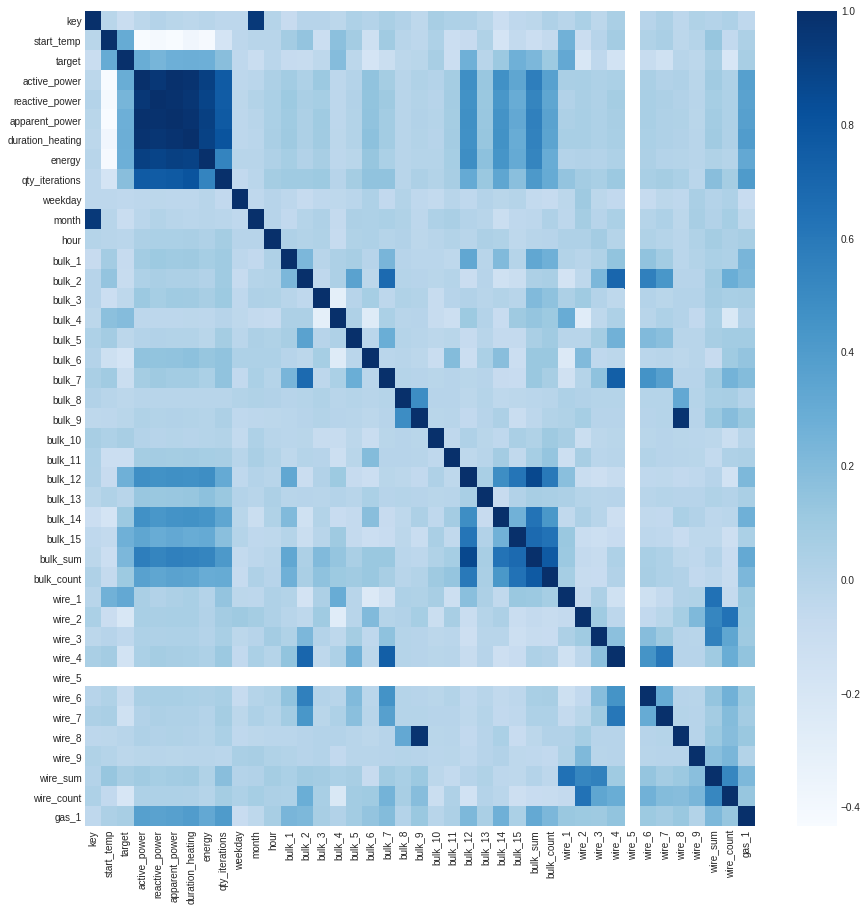

In [ ]:
plt.figure(figsize=(15,15))
sns.heatmap(data_full.corr(), annot=False, cmap='Blues');

Здесь мы видим что признаки энергии и мощностей сильно коррелируют относительно друг друга. А так же отсутсвие корреляции `wire_5` (содержит только нулевые значения). Посмотрим поближе.

Посмотрим на на данные, где корреляция больше 0,9

In [ ]:
def corr_more_09(df):
  df = df.corr()
  df = df[((df != 1) & (df > 0.9))]

  for column in df.columns:
    if df[column].notna().sum() == 0:
      df = df.drop(column, axis=1)

  for idx in df.index:
    if df.loc[idx,:].notna().sum() == 0:
      df = df.drop(idx)

  return df

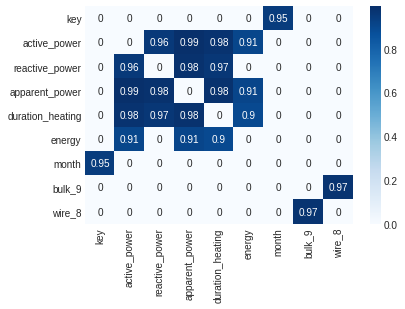

In [ ]:
df_new = corr_more_09(data_full).fillna(0)
sns.heatmap(df_new, annot=True, cmap='Blues');

Посмотрим на корреляцию признаков к целевому признаку.

interval columns not set, guessing: ['key', 'start_temp', 'target', 'active_power', 'reactive_power', 'apparent_power', 'duration_heating', 'energy', 'qty_iterations', 'weekday', 'month', 'hour', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15', 'bulk_sum', 'bulk_count', 'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6', 'wire_7', 'wire_8', 'wire_9', 'wire_sum', 'wire_count', 'gas_1']


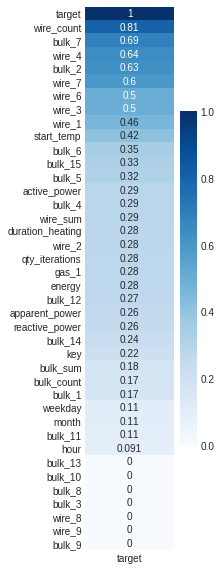

In [ ]:
phik_matrix = data_full.phik_matrix();
plt.figure(figsize=(2,10))
sns.heatmap(phik_matrix['target'].sort_values(ascending=False).to_frame(), annot=True, cmap='Blues');

Следует удалить признаки, коррелирующие между собой, но оставить признаки, которые больше всего оказывают влияние на конечную температуру. Удалим следующие столбцы: `wire_5`, `reactive_power`, `apparent_power`, `energy`, `duration_heating`, `bulk_9`. Так же удалим `key`, так как это не признак. Остальные пока оставим и вернёмся к ним, если модель будет плохо обучаться и целевая метрика не будет достигнута.

In [ ]:
data_full = data_full.drop(['wire_5', 'reactive_power', 'apparent_power', 'energy', 'key', 'duration_heating', 'bulk_9'], axis=1)
data_full.shape

(2325, 34)

In [ ]:
pd.set_option('display.max_columns', 150)
data_full

,start_temp,target,active_power,qty_iterations,weekday,month,hour,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_sum,bulk_count,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9,wire_sum,wire_count,gas_1
0,"1,571.0000","1,613.0000",4.8781,5,4,5,11,0.0000,0.0000,0.0000,43.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,206.0000,0.0000,150.0000,154.0000,553.0000,4,60.0600,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,60.0600,1,29.7500
1,"1,581.0000","1,602.0000",3.0526,4,4,5,11,0.0000,0.0000,0.0000,73.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,206.0000,0.0000,149.0000,154.0000,582.0000,4,96.0523,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,96.0523,1,12.5556
2,"1,596.0000","1,599.0000",2.5259,5,4,5,12,0.0000,0.0000,0.0000,34.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,205.0000,0.0000,152.0000,153.0000,544.0000,4,91.1602,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,91.1602,1,28.5548
3,"1,601.0000","1,625.0000",3.2093,4,4,5,12,0.0000,0.0000,0.0000,81.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,207.0000,0.0000,153.0000,154.0000,595.0000,4,89.0635,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,89.0635,1,18.8412
4,"1,576.0000","1,602.0000",3.3472,4,4,5,13,0.0000,0.0000,0.0000,78.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,203.0000,0.0000,151.0000,152.0000,584.0000,4,89.2382,9.1146,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,98.3528,2,5.4137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,"1,570.0000","1,591.0000",3.2107,4,1,8,0,0.0000,0.0000,21.0000,0.0000,0.0000,0.0000,0.0000,0.0000,90.0000,0.0000,256.0000,0.0000,129.0000,223.0000,719.0000,5,89.1509,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,89.1509,1,7.1257
2325,"1,554.0000","1,591.0000",4.2031,6,1,8,1,0.0000,0.0000,0.0000,63.0000,0.0000,0.0000,0.0000,0.0000,122.0000,0.0000,256.0000,0.0000,129.0000,226.0000,796.0000,5,114.1795,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,114.1795,1,9.4126
2326,"1,571.0000","1,589.0000",2.2124,3,1,8,1,0.0000,0.0000,0.0000,85.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,230.0000,0.0000,124.0000,226.0000,665.0000,4,94.0867,9.0480,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,103.1347,2,6.2717
2327,"1,591.0000","1,594.0000",3.4087,5,1,8,1,0.0000,0.0000,90.0000,0.0000,0.0000,0.0000,0.0000,0.0000,101.0000,0.0000,206.0000,0.0000,129.0000,207.0000,733.0000,5,118.1107,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,118.1107,1,14.9537


### Разделение данных на выборки

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data_full.drop('target', axis=1), data_full['target'], test_size=.2, random_state=seed)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1860, 33), (465, 33), (1860,), (465,))

## Построение моделей машинного обучения 

Обучим следующие модели:   
- LightGBM
- CatBoost
- LinearRegression
- Ridge

Записывать результаты будем в талицу.

In [ ]:
models = []
scores = []

### LGBMRegressor

Оценивать модель будем кросс-валидацией

In [ ]:
gbm_params = {
    'learning_rate': [0.01, 0.1, 1],
    'n_estimators': range(100,220,10)
}

gbm_model = lgb.LGBMRegressor(random_state=seed)

grid_gbm = GridSearchCV(gbm_model, gbm_params, scoring='neg_mean_absolute_error', cv=5)

In [ ]:
%%time
grid_gbm.fit(x_train, y_train)

In [ ]:
print('MAE кросс-валидации лучшей модели', abs(round(grid_gbm.best_score_, 2)))

Не плохой результат, запишем модель и результат.

In [ ]:
models.append('LGBMRegressor')
scores.append(abs(round(grid_gbm.best_score_, 2)))
gbm_model = grid_gbm.best_estimator_
grid_gbm.best_estimator_

LGBMRegressor(random_state=29082022)

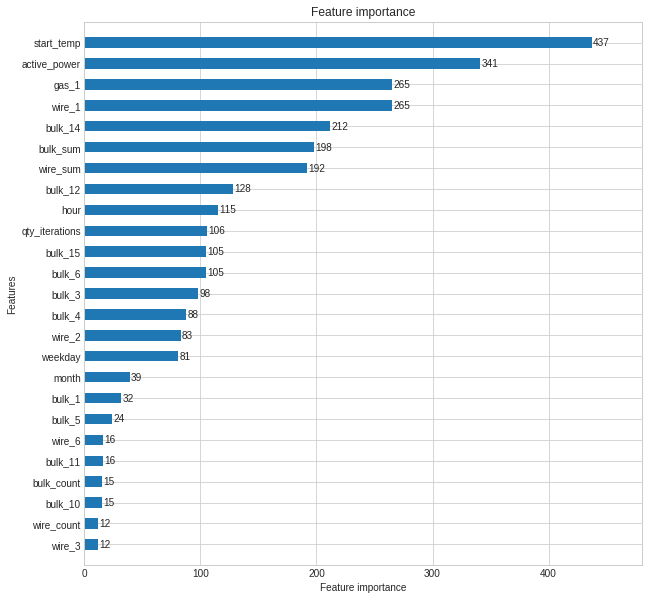

In [ ]:
lgb.plot_importance(gbm_model, height=.5, figsize=(10,10));

### CatBoostRegressor

In [ ]:
cat_params = {'learning_rate': [0.01, 0.1, 0.2]}

cat_model = CatBoostRegressor(random_state=seed, loss_function='MAE', verbose=0)
grid_cat = GridSearchCV(cat_model, cat_params, scoring='neg_mean_absolute_error', cv=5)

In [ ]:
%%time
grid_cat.fit(x_train, y_train)

CPU times: user 2min 6s, sys: 6.58 s, total: 2min 13s
Wall time: 1min 12s


GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x7f2a5ad47750>,
             param_grid={'learning_rate': [0.01, 0.1, 0.2]},
             scoring='neg_mean_absolute_error')

In [ ]:
print('MAE кросс-валидации лучшей модели', abs(round(grid_cat.best_score_, 2)))

MAE кросс-валидации лучшей модели 5.88


Результат чуть лучше, запишем модель и результат.

In [ ]:
models.append('CatBoostRegressor')
scores.append(abs(round(grid_cat.best_score_, 2)))
cat_model = grid_cat.best_estimator_
grid_cat.best_estimator_

### LinearRegression

In [ ]:
lr_params = {'normalize': [True, False],
           'copy_X': [True, False],
           'fit_intercept': [True, False]}

lr_model = LinearRegression()
grid_lr = GridSearchCV(lr_model, lr_params, scoring='neg_mean_absolute_error', cv=5, verbose=1)

In [ ]:
%%time
grid_lr.fit(x_train, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
CPU times: user 1.1 s, sys: 3.42 s, total: 4.51 s
Wall time: 4.49 s


GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring='neg_mean_absolute_error', verbose=1)

In [ ]:
print('MAE кросс-валидации лучшей модели', abs(round(grid_lr.best_score_, 2)))

MAE кросс-валидации лучшей модели 6.27


In [ ]:
models.append('LinearRegression')
scores.append(abs(round(grid_lr.best_score_, 2)))
lr_model = grid_lr.best_estimator_
grid_lr.best_estimator_

LinearRegression()

### Ridge Regression

In [ ]:
rr_params = {'solver': ['auto', 'svd', 'cholesky', 'saga', 'lbfgs'],
             'alpha': range(0, 20)}

rr_model = Ridge(random_state=seed)
grid_rr = GridSearchCV(rr_model, rr_params, scoring='neg_mean_absolute_error', cv=5, verbose=1)

In [ ]:
%%time
grid_rr.fit(x_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
CPU times: user 6.57 s, sys: 3.38 s, total: 9.95 s
Wall time: 9.86 s


GridSearchCV(cv=5, estimator=Ridge(random_state=29082022),
             param_grid={'alpha': range(18, 20),
                         'solver': ['auto', 'svd', 'cholesky', 'saga',
                                    'lbfgs']},
             scoring='neg_mean_absolute_error', verbose=1)

In [ ]:
print('MAE кросс-валидации лучшей модели', abs(round(grid_rr.best_score_, 2)))

MAE кросс-валидации лучшей модели 6.05


In [ ]:
models.append('RidgeRegression')
scores.append(abs(round(grid_rr.best_score_, 2)))
rr_model = grid_rr.best_estimator_
grid_rr.best_estimator_

Ridge(alpha=19, random_state=29082022)

## Анализ работы моделей и подготовка отчёта

### Сравнение моделей

Запишем наши результаты в таблицу

In [ ]:
report = pd.DataFrame({'MAE_scores_cv': scores}, index=models).sort_values('MAE_scores_cv')
report

,MAE_scores_cv
CatBoostRegressor,5.8800
RidgeRegression,6.0500
LGBMRegressor,6.0800
LinearRegression,6.2700


На кросс-валидации у нас лучшие результаты показал CatBoostRegressor с параметрами    
`learning_rate=0.1, loss_function='MAE`

### Проверка модели на тестовой выборке

Посмотрим результат лучшей модели на тестовой выборке

In [ ]:
print('MAE на тестовой выборке', mean_absolute_error(y_test, cat_model.predict(x_test)))

MAE на тестовой выборке 5.997065831012037


MAE > 8.7 — 0 sp   
   	7.6 < MAE ≤ 8.7 — 4 sp   
   	6.8 < MAE ≤ 7.6 — 4.5 sp  
   	6.3 < MAE ≤ 6.8 — 5 sp  
   	6.0 < MAE ≤ 6.3 — 5.5 sp  
   	**MAE ≤ 6.0 — 6 sp**

Модель можно считать успешной

### Значимость признаков

Оценим значимость признаков для нашей лучшей модели

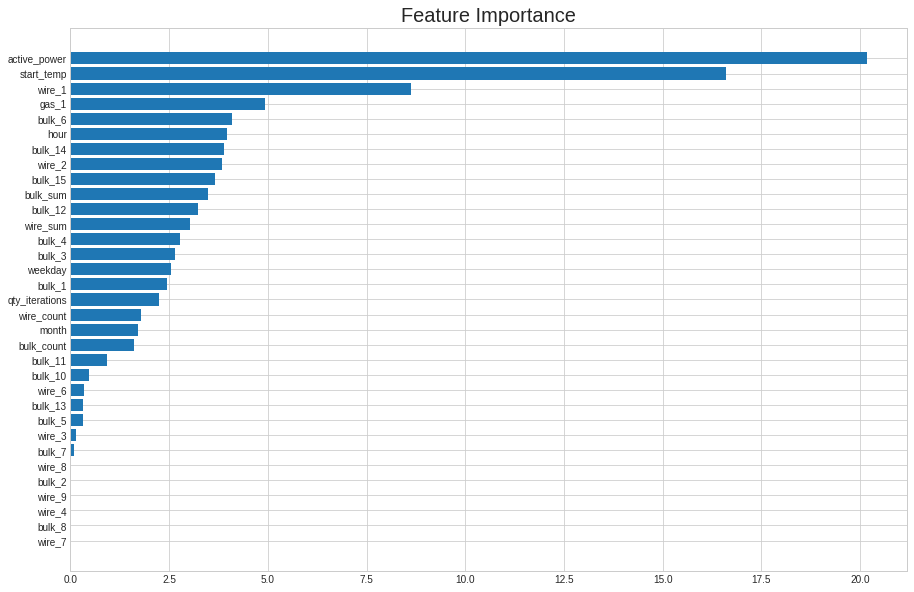

In [ ]:
feature_importance = cat_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(15, 10))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(x_test.columns)[sorted_idx])
plt.title('Feature Importance', size=20);

Здесь как и ожидалось на первом месте активная мощность (сколько потребовалось мощности, до такой температуры и нагревали) далее идёт начальная температура, что тоже логично. Основными факторами, требующих дополнительного нагрева, а следовательно и энергии являются:   
- Легирующий элемент в проволочном виде №1,
- Объём потребляемого газа (вероятнее всего чем больше подаётся газа, тем больше требуется нагревать сплав)
- Легирующий элемент в сыпучем виде №6 (возможно элемент является тугоплавким и для его расплавления требуется больше нагрева --> энергии)
- Далее существует зависимость от часа времени суток. Возможно это связанно со сменностью или какими ещё другими факторами, происходящими в течении дня. Этот вопрос следует изучить глубже.

### Отчёт по решению

Перед нами стояла задача построить модель, которая предскажет температуру стали. В будующем такая модель должна помочь оптимизировать затраты на этапе обработки стали.

Нами были изучены данные и выявлены некоторые аномалии:
- Одно значение реактивной мощности было аномально отрицательным (заменено расчётным значением)
- Большое кол-во итераций нагрева сплава до 16 (возможно это другой сплав) (не удалено)
- Большой объём затрачиваемого газа при перемешивании (возможно связано с техническими неполадками) (не удалено)
- Низкая температура плавления ниже 1400 градусов (возможно это другой сплав) (удалено)
- Большая длительность нагрева сплава (возможно это другой сплав) (не удалено)

Были созданы следующие дополнительные признаки:
- Начальная температура
- Час начала нагрева
- День недели   

Были так же добавлены признаки связанные с мощностью и энергией, которые в последствии были удалены из-за мультиколлинеарности. Был оставлен только признак `active_power` Так же был удалён признак легирующего элемента `wire_5`, так как он не использовался во время сбора данных и ключ `key`, так как не имеет технологической значимости.

Все данные были объеденены в одну таблицу по ключу `key` (значения просуммированы) и переданы следующим моделям для обучения:
- LGBMRegressor
- CatBoostRegressor
- LinearRegression
- Ridge

Лучшие результаты средней абсолютной ошибки (МАЕ) кросс-валидации получила модель *CatBoostRegressor* с параметрами *learning_rate=0.1, loss_function='MAE'*. На тесте эта модель получила значение **МАЕ = 5.997**.

Следует отметить значимость признака часа суток для данной модели. Вероятнее всего здесь есть зависимость от смены или другого признака связанного со временем проведения обработки и для этого потребуются дополнительные исследования. Так же стоит отметить что есть и малозначимые признаки из нескольких легирующих элементов.